# ORFit for RMNIST

# 0. Imports

In [1]:
from typing import Callable
from functools import partial

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import seaborn as sns
import flax.linen as nn
from jax import jacrev, vmap, jit
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt
import pandas as pd

from rebayes.utils import datasets
from rebayes.utils.utils import get_mlp_flattened_params
from rebayes.orfit import ORFitParams, RebayesORFit
from rebayes.ekf import RebayesEKF
from rebayes.diagonal_inference import DEKFParams

/home/peter0414/rebayes/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

In [3]:
def dekf_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_diag_cov):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = (F * post_diag_cov) @ F.T

    return pred_mean, pred_cov

In [4]:
class CNN(nn.Module):
    dim_out: int
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        x = x.reshape((1, 28, 28, 1))
        x = nn.Conv(6, (5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, (2, 2), padding="SAME")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x).ravel()
        return x

In [5]:
# # Define the MLP model
# input_dim, hidden_dims, output_dim = 784, [100, 50, 10, 10,], 1
# model_dims = [input_dim, *hidden_dims, output_dim]
# _, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
# print(flat_params.shape)

# # L2 loss
# loss_fn = lambda w, x, y: (apply_fn(w, x) - y)**2

In [5]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

In [6]:
def evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, method='orfit', multi_pass=False):
    map_trench_1 = (y_train  >= 0) & (y_train <= 45)
    map_trench_2 = (y_train >= 90) & (y_train <= 135)
    map_trench = map_trench_1 | map_trench_2

    y_eval = y_train[map_trench]
    X_eval = X_train[map_trench]

    ix_target = 0
    n_rotations = 300
    rotations = np.linspace(0, 180, n_rotations)
    x_target = np.array(X_eval[ix_target]).reshape(28, 28)
    y_init = float(y_eval[ix_target].item())
    x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

    X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
    X_target = np.array(X_target.reshape(-1, 28, 28))
    X_target, y_target = generate_rotated_images(X_target, rotations)

    X_target = X_target.reshape(-1, 28 ** 2)

    # To TPU
    X_target = jnp.array(X_target)
    y_target = jnp.array(y_target)

    if multi_pass:
        # 10 passes over the dataset
        n_passes = 10
        X_eval, y_eval = jnp.concatenate([X_eval] * n_passes), jnp.concatenate([y_eval] * n_passes)
        idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_eval)))
        X_eval, y_eval = X_eval[idx_perm], y_eval[idx_perm]

    if method == 'orfit':
        # Initialize orfit estimator
        orfit_params = ORFitParams(
            initial_mean=flat_params,
            apply_function=apply_fn,
            loss_function=lambda w, x, y: (apply_fn(w, x) - y)**2,
            memory_size=len(X_eval)//30,
        )
        estimator = RebayesORFit(orfit_params)

        # Run the estimator
        bel, _ = estimator.scan(X_eval, y_eval)

        # Compute posterior predictive moments
        pred_mean_test, pred_cov_test = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
        pred_mean_test, pred_cov_test, pred_std_test = pred_mean_test.squeeze(), jnp.diag(pred_cov_test.squeeze()), jnp.sqrt(pred_cov_test.squeeze())

        pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_target, bel.mean, bel.basis)
        pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

    elif method == 'fdekf':
        # Initialize fdekf estimator
        fdekf_params = DEKFParams(
            initial_mean=flat_params,
            initial_cov_diag=1e-1 * jnp.ones_like(flat_params),
            dynamics_cov_diag=1e-5*jnp.ones_like(flat_params),
            emission_mean_function=apply_fn,
            emission_cov_function=lambda x, u: jnp.eye(1)*0,
        )
        estimator = RebayesEKF(fdekf_params, 'fdekf')

        # Run the estimator
        bel, _ = estimator.scan(X_eval, y_eval)

        # Compute posterior predictive moments
        pred_mean_test, pred_cov_test = vmap(dekf_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.cov)
        pred_mean_test, pred_cov_test, pred_std_test = pred_mean_test.squeeze(), jnp.diag(pred_cov_test.squeeze()), jnp.sqrt(pred_cov_test.squeeze())

        pred_mean, pred_cov = vmap(dekf_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_target, bel.mean, bel.cov)
        pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())
    
    else:
        raise ValueError('Method error')
    
    metric_mae, metric_rmse = jnp.abs(pred_mean_test - y_test).mean(), jnp.sqrt(jnp.power(pred_mean_test - y_test, 2).mean())
    print(f'Test-set MAE: {metric_mae:.2f}, RMSE: {metric_rmse:.2f}')

    # Plot results
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, pred_mean_test, alpha=0.5, edgecolors=None)
    ax.set_ylabel("y-hat")
    ax.set_xlabel("y-true")

    # Trenches
    xtrench1 = jnp.linspace(45, 90, 100)
    xtrench2 = jnp.linspace(135, 180, 100)
    ymin, ymax = plt.ylim()

    ax.axvline(x=45, c="tab:gray", linestyle="--")
    ax.axvline(x=90, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

    ax.axvline(x=135, c="tab:gray", linestyle="--")
    ax.axvline(x=180, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

    # plt.axhline(y=0, c="black")
    ax.plot([0, 180], [0, 180], c="black")

    ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(alpha=0.5)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(y_target, pred_mean)

    lbound = pred_mean - 1.96 * pred_std
    ubound = pred_mean + 1.96 * pred_std
    ax.fill_between(y_target, lbound, ubound, alpha=0.2)
    ax.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
    ax.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

    ax.set_xlabel("y-true")
    ax.set_ylabel("y-hat")

    ymin, ymax  = plt.ylim()


    ax.axvline(x=45, c="tab:gray", linestyle="--")
    ax.axvline(x=90, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

    ax.axvline(x=135, c="tab:gray", linestyle="--")
    ax.axvline(x=180, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

    ax.plot([0, 180], [0, 180], c="black", linewidth=1)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3)

# 1. R-MNIST without Trenches

In [7]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [8]:
key = jr.PRNGKey(314)
key_init, key_train = jr.split(key)

dummy_input = jnp.ones(shape=dim_input)

# Define the CNN model
cnn_model = CNN(1)
params = cnn_model.init(key, dummy_input)
flat_params, unflatten_fn = ravel_pytree(params)

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

apply_fn = partial(apply, model=cnn_model, unflatten_fn=unflatten_fn)

# L2 loss
loss_fn = lambda w, x, y: (apply_fn(w, x) - y)**2

In [9]:
num_eval = 100

X_eval = X_train[:num_eval]
y_eval = y_train[:num_eval]

Inifinite memory, no SV threshold

In [9]:
# Initialize orfit estimator
orfit_params = ORFitParams(
    initial_mean=flat_params,
    apply_function=apply_fn,
    loss_function=lambda w, x, y: (apply_fn(w, x) - y)**2,
    memory_size=len(X_eval),
)
estimator = RebayesORFit(orfit_params)

In [10]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_eval, y_eval)

Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 107.36it/s]


In [11]:
# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

  0%|          | 0/100 [00:00<?, ?it/s]

Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 107.32it/s]


In [12]:
metric_mae = jnp.abs(pred_mean - y_test).mean()
metric_mae

Array(24.923655, dtype=float32)

In [13]:
metric_rmse = jnp.sqrt(jnp.power(pred_mean - y_test, 2).mean())
metric_rmse

Array(31.532495, dtype=float32)

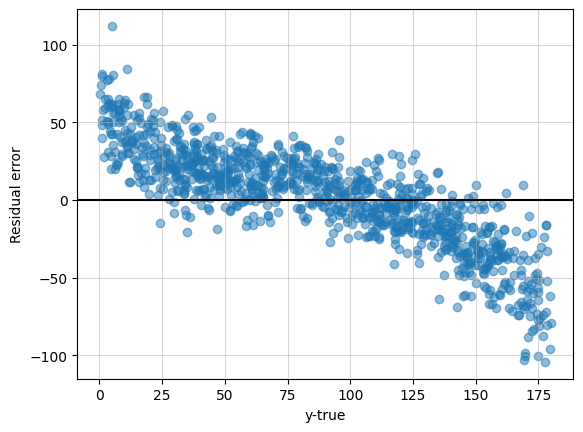

In [14]:
residual_err = pred_mean - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

Infinite memory, SV threshold = $4\sqrt{476227}/\sqrt{3}$

In [15]:
# Initialize orfit estimator
orfit_params = ORFitParams(
    initial_mean=flat_params,
    apply_function=apply_fn,
    loss_function=lambda w, x, y: (apply_fn(w, x) - y)**2,
    memory_size=len(X_eval),
    sv_threshold=4*jnp.sqrt(flat_params.shape[0])/jnp.sqrt(3)
)
estimator = RebayesORFit(orfit_params)

In [16]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_eval, y_eval)

In [17]:
# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 100 iterations:  20%|██        | 20/100 [00:00<00:00, 146.48it/s]

Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 107.58it/s]


In [18]:
metric_mae = jnp.abs(pred_mean - y_test).mean()
metric_mae

Array(35.506886, dtype=float32)

In [19]:
metric_rmse = jnp.sqrt(jnp.power(pred_mean - y_test, 2).mean())
metric_rmse

Array(43.098766, dtype=float32)

# 2. R-MNIST with Trenches

## 2.1: Digit "1"

In [10]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=1)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

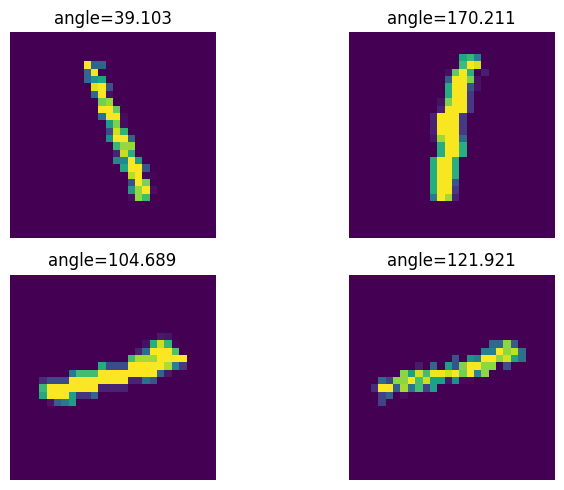

In [11]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

1. $[0, 90]$

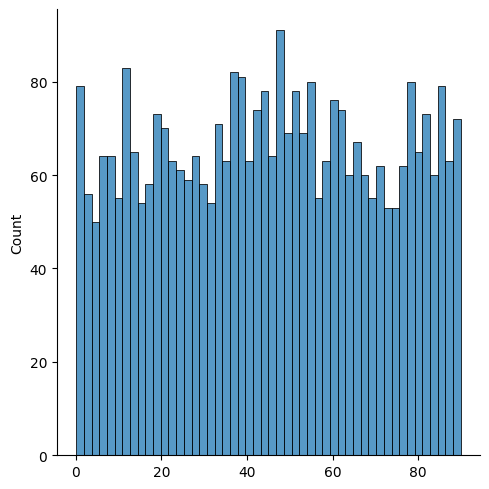

In [63]:
map_trench_1 = (y_train  >= 0) & (y_train <= 90)

y_eval = y_train[map_trench_1]
X_eval = X_train[map_trench_1]
sns.displot(y_eval, bins=50);

In [76]:
# Initialize orfit estimator
orfit_params = ORFitParams(
    initial_mean=flat_params,
    apply_function=apply_fn,
    loss_function=lambda w, x, y: (apply_fn(w, x) - y)**2,
    memory_size=len(X_eval)//30
)
estimator = RebayesORFit(orfit_params)

In [77]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_eval, y_eval)

Running for 3,325 iterations: 100%|██████████| 3325/3325 [00:31<00:00, 105.86it/s]


In [78]:
# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

In [79]:
metric_mae = jnp.abs(pred_mean - y_test).mean()
metric_mae

Array(39.15677, dtype=float32)

In [80]:
metric_rmse = jnp.sqrt(jnp.power(pred_mean - y_test, 2).mean())
metric_rmse

Array(57.32869, dtype=float32)

In [81]:
xtrench = jnp.linspace(90, 180, 200)

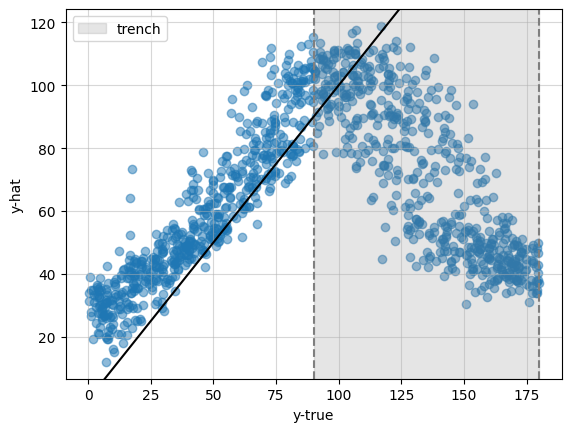

In [82]:
residual_err = pred_mean
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [24]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

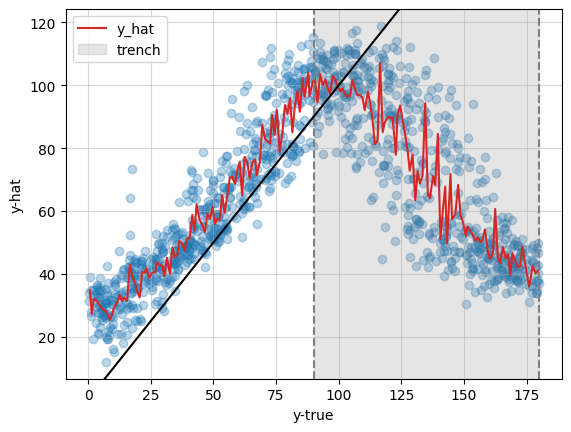

In [25]:
residual_err = pred_mean
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [12]:
ix_target = 0
x_target = np.array(X_eval[ix_target]).reshape(28, 28)
y_init = float(y_eval[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

In [13]:
n_rotations = 300
rotations = np.linspace(0, 180, n_rotations)

In [14]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

In [15]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

X_target = X_target.reshape(-1, 28 ** 2)

# To TPU
X_target = jnp.array(X_target)
y_target = jnp.array(y_target)

In [30]:
# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_target, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

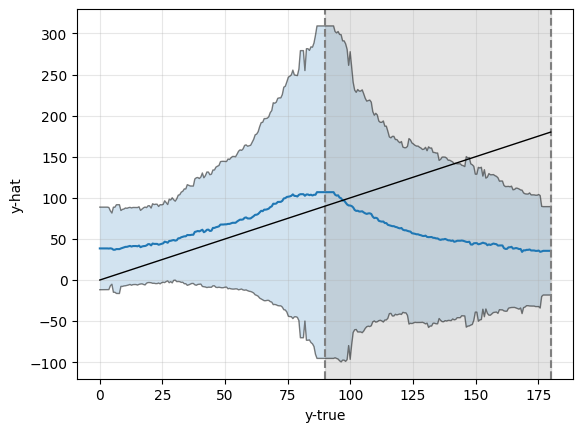

In [31]:
plt.plot(y_target, pred_mean)

lbound = pred_mean - 1.96 * pred_std
ubound = pred_mean + 1.96 * pred_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.plot([0, 180], [0, 180], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

2. $[0, 45] \cup [90, 135]$

### 2.1.1 ORFit: Single Pass

In [12]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

Running for 3,319 iterations:  94%|█████████▍| 3135/3319 [00:28<00:01, 105.94it/s]

### 2.1.2 EKF

Running for 3,319 iterations: 100%|██████████| 3319/3319 [00:03<00:00, 989.35it/s] 


Test-set MAE: 35.99, RMSE: 47.47


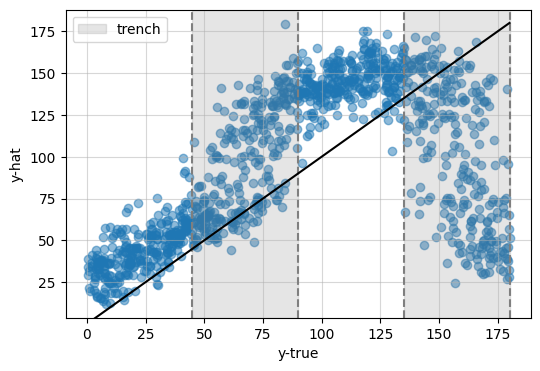

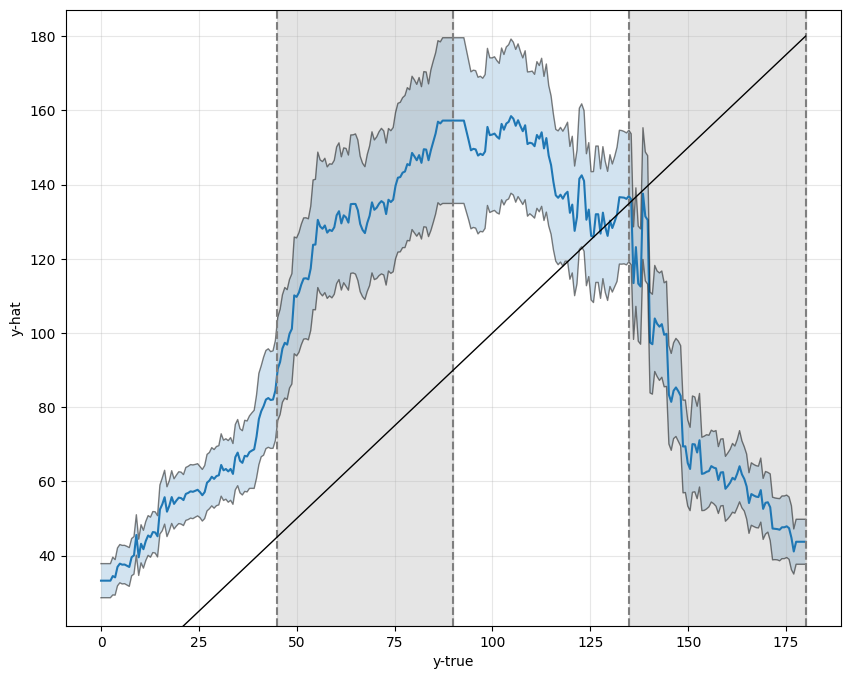

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.1.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

  0%|          | 0/33190 [00:00<?, ?it/s]

## 2.2: Digit "2"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

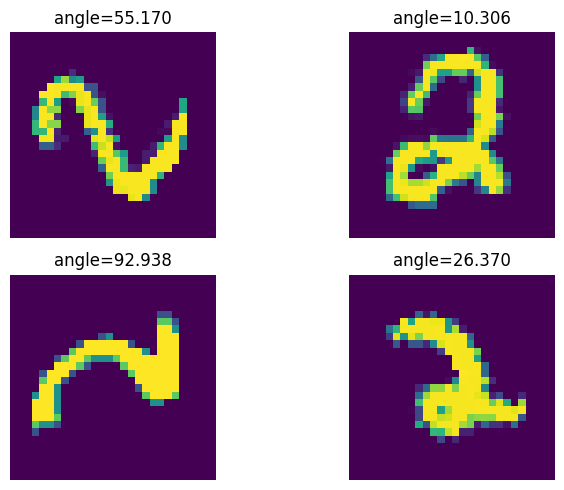

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.2.1 ORFit: Single Pass

Running for 2,923 iterations: 100%|██████████| 2923/2923 [00:27<00:00, 106.51it/s]


Test-set MAE: 18.81, RMSE: 31.02


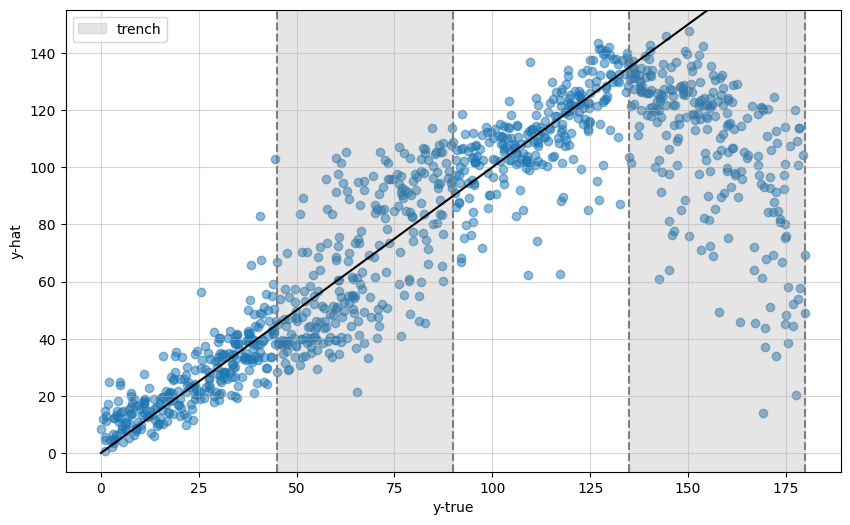

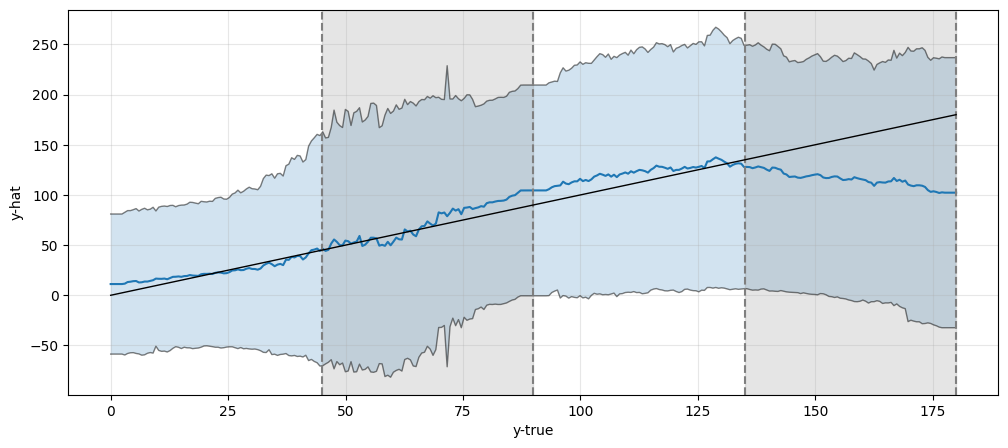

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.2.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

Running for 2,923 iterations: 100%|██████████| 2923/2923 [00:02<00:00, 993.30it/s] 


### 2.2.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

Running for 29,230 iterations:  10%|▉         | 2922/29230 [01:02<06:54, 63.39it/s]

## 2.3 Digit "3"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=3)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.3.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.3.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.3.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.4 Digit "4"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=4)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.4.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.4.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.4.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.5 Digit "5"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=5)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.5.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.5.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.5.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.6 Digit "6"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=6)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.6.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.6.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.6.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.7 Digit "7"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=7)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.7.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.7.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.7.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.8 Digit "8"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=8)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.8.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.8.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.8.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)

## 2.9 Digit "9"

In [ ]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=9)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, *dim_input = X_train.shape

In [ ]:
ixs = [0, 10, 20, 30,]

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_test[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_test[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

### 2.9.1 ORFit: Single Pass

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test)

### 2.9.2 EKF

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, 'fdekf')

### 2.9.3 ORFit: 10 Passes

In [ ]:
evaluate_trenches(flat_params, apply_fn, X_train, y_train, X_test, y_test, multi_pass=True)